In [184]:
import numpy as np
import time
import sys
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import pandas as pd

In [185]:
###############################################################################
#VGG
###############################################################################

#It specifies what (convolution, batch normalization, ReLU activation, dropout) are needed to build the network.

#Dropout is a regularization technique commonly used in neural networks to prevent overfitting.
#It works by randomly setting a fraction of input units to zero during the training process, which helps to prevent the model from relying too heavily on specific input features and encourages the network to learn more robust and generalizable representations.

#this class encapsulates the operations of a single convolutional block, including convolution, batch normalization, ReLU activation, and optionally dropout.

#stride: step size
#padding: ensures that the output feature map has the same spatial dimensions as the input.

class vgg16_conv_block(nn.Module):
    def __init__(self, input_channels, out_channels, rate=0.3, drop=True):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, 3, 1, 1)  #This line creates a 2D convolutional layer using PyTorch's nn.Conv2d module.
        self.bn = nn.BatchNorm2d(out_channels) # normalize the activations of the convolutional layer in the neural network.
        self.relu = nn.ReLU(inplace=True) #introduces non-linearity (-ve --> zeros)
        self.dropout = nn.Dropout(rate)
        self.drop = drop

    def forward(self, x):  #This method defines the forward pass of the convolutional block.
        x = self.relu(self.bn(self.conv(x)))
        if self.drop:
            x = self.dropout(x)
        return x


# It specifies how many (convolutional blocks) to build and what features each network should have
# creating a sequence of convolutional blocks followed by a max-pooling layer
# 0.3 corresponds to the dropout rate for the convolutional blocks within each layer, and the second value 0.4 represents the dropout rate for the fully connected layers in the VGG16 model.

def vgg16_layer(input_channels, out_channels, num, dropout=[0.3, 0.4], pool=True):
    layers = []
    for i in range(num):  #creating convolutional blocks using the vgg16_conv_block function.
        layers.append(vgg16_conv_block(input_channels, out_channels, dropout[0]))
        input_channels = out_channels  #ensuring that subsequent blocks receive the correct number of input channels.
    if pool:
        layers.append(nn.MaxPool2d(2, 2))  #reduces the spatial dimensions of the feature maps by a factor of 2
    return nn.Sequential(*layers)

# This is like the blueprint for the entire neural network.
# It specifies how to arrange the (layers) and what features each layers should have.

class ModifiedVGG16(nn.Module):
    def __init__(self):
        super(ModifiedVGG16, self).__init__()
        self.features = nn.Sequential(
            vgg16_layer(1, 16, 2),  # Adjust input channels to 1
            vgg16_layer(16, 32, 2),
            vgg16_layer(32, 64, 2),
            vgg16_layer(64, 128, 2),
            vgg16_layer(128, 256, 2, pool=False),
            vgg16_layer(256, 512, 2, pool=False)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(512, 10, bias=True)
        )

    # defines how data flows through the network during the forward pass.
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

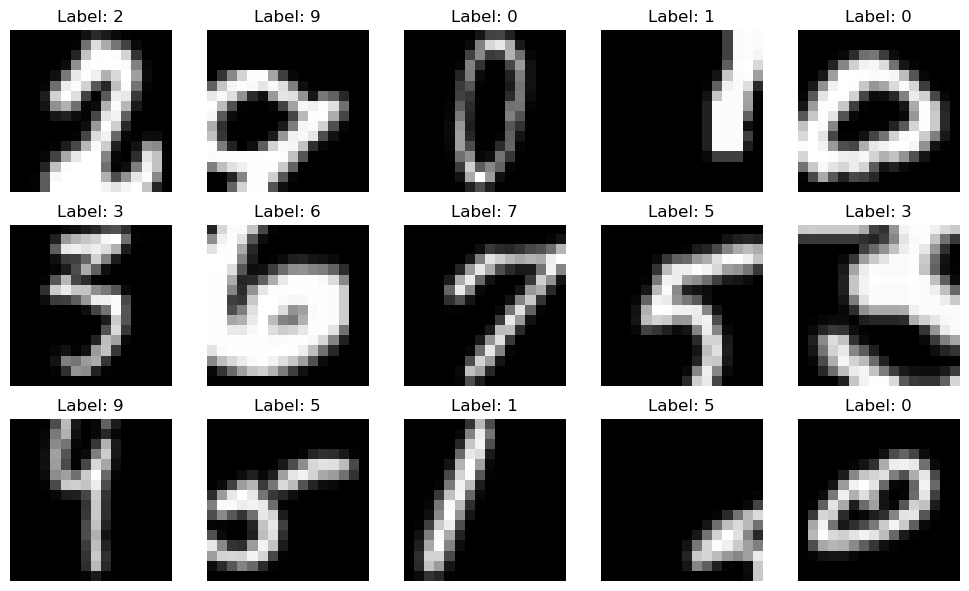

In [186]:
# Define transforms for the dataset

# ***** Add more data augmenation
#   random rotation, horizontal flip, random affine transformation,
#   random vertical flip, random perspective transformation, random brightness adjustment,
#   and random contrast adjustment   **********

transform_plus = transforms.Compose([
    # transforms.RandomAffine(10),
    # transforms.RandomRotation(10),
    transforms.RandomResizedCrop((16,)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full MNIST dataset
trainset_full = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform_plus)
testset_full = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform_plus)

# Define the number of samples you want to use for training and testing
num_train_samples = 5000  # Example: Use 5000 samples for training
num_test_samples = 1000   # Example: Use 1000 samples for testing

# Create subsets of the full dataset
train_indices = torch.randperm(len(trainset_full))[:num_train_samples]
test_indices = torch.randperm(len(testset_full))[:num_test_samples]

trainset= Subset(trainset_full, train_indices)
testset= Subset(testset_full, test_indices)

# Load a batch of images and labels from the trainset
batch_size = 15
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Define a function to display a grid of images
def show_images(images, labels, nrows=3, ncols=5, figsize=(10, 6)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Iterate over the trainloader to get a batch of data
for images, labels in trainloader:
    # Display the images
    show_images(images, labels)
    break  # Break after displaying the first batch

In [ ]:
# Define the classes
classes = tuple(str(i) for i in range(10))  # MNIST has 10 classes, digits 0 to 9

net = ModifiedVGG16()
net = nn.DataParallel(net)
net.to(device)
net.train()


#      ***students can modify the training hyperparameters
epoch_num=20 #the number of times the entire dataset will be fed forward and backward through the network during training.
batch_num=256 #the number of training examples used in each iteration of training.
learning_rate=0.05  #Determines the step size at which the model parameters are updated during training using the gradient descent algorithm.
loss_fn=nn.CrossEntropyLoss()

# This function test is used to evaluate the performance of a neural network model (net) on a given dataset (dataloader).
def test(net, dataloader):
    test_loss=0
    test_correct=0
    time=0
    net.eval()
    with torch.no_grad():
        idx=0
        for data in dataloader:
            inputs, labels =data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs=net(inputs)
            test_loss += loss_fn(outputs, labels).item()*len(labels)
            #Compare the predicted class (index of the maximum value in the output tensor) with the actual labels to determine the number of correct predictions. Sum up the correct predictions across all the batches.
            test_correct += (torch.max(outputs.data,1)[1] == labels).sum()
            time += 1

    return(test_loss/len(testset), test_correct/len(testset)*100)

#   ***** use two more optimizer, two different learning rates and see the results ******
opt=optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-6, nesterov=True) #Specifies the optimizer used for updating the model parameters based on the computed gradients

train_num=len(trainset)//batch_num

#These lists will store the loss and accuracy values during training and testing.
los=[]
cor=[]
train_los=[]
train_cor=[]
test_los=[]
test_cor=[]

#These variables store the best model's performance metrics, such as accuracy, loss, learning rate, and epoch number.
net_corr, net_los,net_train_los, net_train_corr, net_lr, net_epoch = 0, 0, 0, 0, 0, 0

#These tensors are initialized to store the training and testing accuracies for each epoch.
train_cor = torch.zeros(epoch_num)  # Initialize train_cor tensor
test_cor = torch.zeros(epoch_num)   # Initialize test_cor tensor

#Creates a data loader for the training and testing dataset (trainset, testset) to load batches of training data.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_num, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100)

for epoch in range(epoch_num):
    loss_avg=0
    train_time=0
    correct=0
    num_img=0

    # Iterates over batches of data from the trainloader, which contains batches of training images and their corresponding labels

    for data in trainloader:  #iterates over batches of data from the trainloader, which contains batches of training images and their corresponding labels

        # Separates inputs (images) and labels from the current batch
        inputs, labels = data

        # Moves inputs and labels to the specified device (e.g., GPU)
        inputs=inputs.to(device)
        labels=labels.to(device)

        net.train() # Sets the model to training mode
        outputs=net(inputs)    # Performs forward pass: computes outputs (predictions) of the model for the input images

        loss=loss_fn(outputs, labels)     # Computes the loss between the predicted outputs and the ground truth labels

        loss.to(device)     # Moves the loss tensor to the specified device

        opt.zero_grad()     # Clears the gradients of all optimized tensors

        loss.backward()     # Backpropagates the gradients: computes gradients of the loss with respect to model parameters

        torch.nn.utils.clip_grad_norm_(net.parameters(), 20)      # Clips gradients to prevent exploding gradients problem

        opt.step()     # Updates the model parameters (weights) based on the computed gradients and the optimizer's update rule

        # Updates training statistics

        train_time+=1
        loss_avg += loss.item()*len(labels)
        predict = torch.max(outputs.data,1)[1]
        correct += (predict == labels).sum()
        num_img += len(labels)
        sys.stdout.flush()
    print('\r', end="")

    # Evaluates the model on the test dataset and retrieves the test loss and accuracy

    los2,cor2 = test(net, testloader)
    print('Training: {}/{} epoch, Learning rate: {:.10f}, Average Loss:{:.2f}, Accuracy: {:.2f}%, Test Loss:{:.2f}, Test accuracy:{:.2f}%'
          .format(epoch+1,epoch_num, opt.state_dict()['param_groups'][0]['lr'], loss_avg/num_img, correct/num_img*100,los2, cor2.item()))

    los.append(los2)
    cor.append(cor2)
    train_cor[epoch] = correct/num_img*100  # Update train_cor tensor
    test_cor[epoch] = cor2.item()           # Update test_cor tensor
    train_los.append(loss_avg/num_img)
    test_los.append(los2)
    if net_corr < cor2: #This condition checks if the current test accuracy (cor2) is greater than the previously recorded best test accuracy (net_corr).
        net_corr, net_los,net_train_los, net_train_corr, net_lr, net_epoch = cor2, los2, loss_avg/num_img,correct/num_img,opt.state_dict()['param_groups'][0]['lr'], epoch+1
    torch.save(net, './net_model.pkl')
    sys.stdout.flush()

print('The {} epoch achieves the best model, Test Loss: {:.4f}, Test accuracy: {:.2f}%'.format(net_epoch, net_los, net_corr))

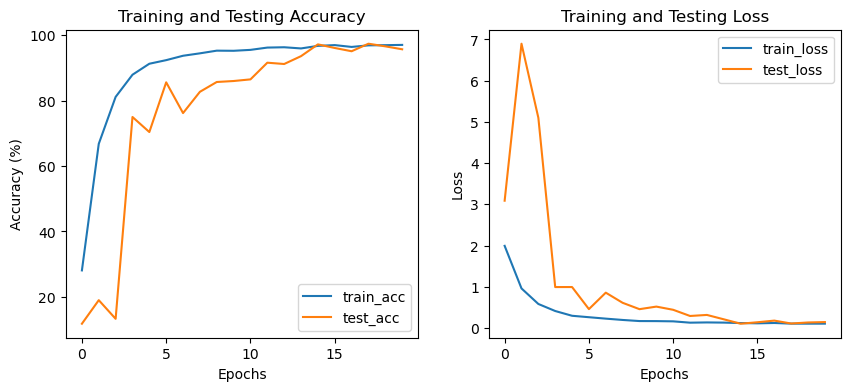

In [ ]:
#  ****** Plotting the training and test loss and accuracy over epochs *******
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Plotting the training testing accuracy
ax1.plot(range(epoch_num), train_cor, label="train_acc")
ax1.plot(range(epoch_num), test_cor, label="test_acc")
ax1.set_title("Training and Testing Accuracy")
ax1.set_ylabel("Accuracy (%)")
ax1.set_xlabel("Epochs")
ax1.legend()

# Plotting the training testing loss
ax2.plot(range(epoch_num), train_los, label="train_loss")
ax2.plot(range(epoch_num), test_los, label="test_loss")
ax2.set_title("Training and Testing Loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
ax2.legend()

plt.show()

In [ ]:
# from torchsummary import summary
from torchinfo import summary

# Define a function to get the input size from the first batch of data
def get_input_size(dataloader):
    # Get the first batch of data
    inputs, _ = next(iter(dataloader))
    # Return the input size
    return inputs.size()[1:]

# Get the input size for MNIST images
input_size = get_input_size(trainloader)

# Print the input size
print("Input size for MNIST images:", input_size)

# Create an instance of the ModifiedVGG16 model
net = ModifiedVGG16().to(device)

# Print the summary
summary(net, input_size=(batch_size, 1, 28, 28))

Input size for MNIST images: torch.Size([1, 28, 28])


Layer (type:depth-idx)                   Output Shape              Param #
ModifiedVGG16                            [15, 10]                  --
├─Sequential: 1-1                        [15, 512, 1, 1]           --
│    └─Sequential: 2-1                   [15, 16, 14, 14]          --
│    │    └─vgg16_conv_block: 3-1        [15, 16, 28, 28]          192
│    │    └─vgg16_conv_block: 3-2        [15, 16, 28, 28]          2,352
│    │    └─MaxPool2d: 3-3               [15, 16, 14, 14]          --
│    └─Sequential: 2-2                   [15, 32, 7, 7]            --
│    │    └─vgg16_conv_block: 3-4        [15, 32, 14, 14]          4,704
│    │    └─vgg16_conv_block: 3-5        [15, 32, 14, 14]          9,312
│    │    └─MaxPool2d: 3-6               [15, 32, 7, 7]            --
│    └─Sequential: 2-3                   [15, 64, 3, 3]            --
│    │    └─vgg16_conv_block: 3-7        [15, 64, 7, 7]            18,624
│    │    └─vgg16_conv_block: 3-8        [15, 64, 7, 7]            37,0

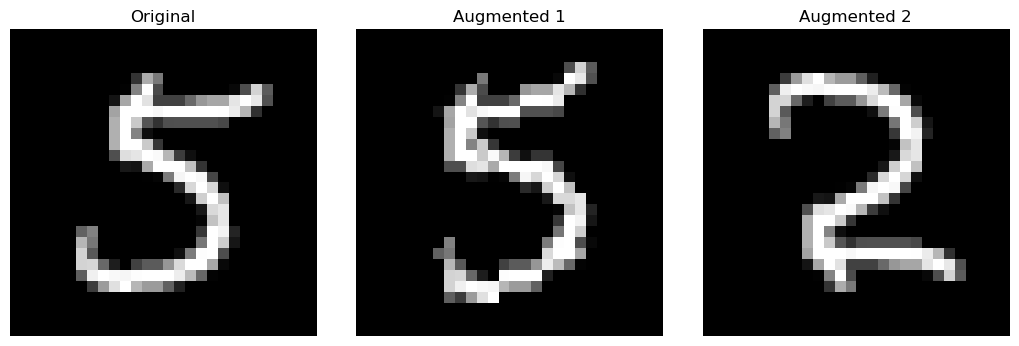

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# Load the MNIST dataset
mnist_train = MNIST(root="./data", train=True, download=True)

# Select a random image from the dataset
index = np.random.randint(0, len(mnist_train))
image, label = mnist_train[index]

# Define transformations
transformations = [
    transforms.RandomRotation(15),               # Random rotation by up to 15 degrees
    transforms.RandomVerticalFlip(60),            # Random vertical flip
]

# Plot original image
plt.figure(figsize=(14, 10))
plt.subplot(3, 4, 1)
plt.title("Original")
plt.imshow(np.array(image), cmap='gray')
plt.axis('off')

# Apply transformations and plot augmented images
for i, transform in enumerate(transformations):
    augmented_image = transform(image)
    plt.subplot(3, 4, i + 2)
    plt.title(f"Augmented {i+1}")
    plt.imshow(np.array(augmented_image), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
